# HISEAS Last Interglacial (LIG) Sea-Surface Temperature (SST) Visualization: Reduced Space Optimal Interpolation

#### Author: Anna Chen (yc4406@columbia.edu)
#### Created on Sep 7, 2025
#### Updated on Dec 8, 2025
Based on "SST_EOF_V2" notebook from summer research and the methodology handbook updated on Nov 19, 2025

**Overview**

The HISEAS Project is an international paleo-climate research collaboration that aims to answer: “**How much and why did Ice Sheets melt during the Last Interglacial?**” (HISEAS).

My role in this project, thus far, has been focusing on quantitatively understanding the spatial and temporal patterns of Sea-Surface Temperature (SST) during the Last Interglacial (LIG, $\approx$ 130-115 ka). 
This is done by reconstructing full-field SST maps across 130.0-115.0 ka at every 0.1 ka time-steps using the LIG SST dataset complied by Hoffman et al. (2017).

**Works Cited**

Evans, M. N., Kaplan, A., & Cane, M. A. (2002). Pacific sea surface temperature field reconstruction from coral δ18O data using reduced space objective analysis. Paleoceanography, 17(1), 7-1-7–13. https://doi.org/10.1029/2000PA000590

Hoffman, J. S., Clark, P. U., Parnell, A. C., & He, F. (2017). Regional and global sea-surface temperatures during the last interglaciation. Science, 355(6322), 276–279. https://doi.org/10.1126/science.aai8464

Kaplan, A., Kushnir, Y., Cane, M. A., & Blumenthal, M. B. (1997). Reduced space optimal analysis for historical data sets: 136 years of Atlantic sea surface temperatures. Journal of Geophysical Research: Oceans, 102(C13), 27835–27860. https://doi.org/10.1029/97JC01734

Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., et al. (2003). Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century. Journal of Geophysical Research: Atmospheres, 108(D14). https://doi.org/10.1029/2002JD002670

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._read_only",
    message="Unknown extension is not supported and will be removed"
)

In [2]:
# ---------------------------------------------------------------------
# Configuration / inputs
# ---------------------------------------------------------------------
excel_file = "SST_Hoffman_Harmonized_AC_ES_no_V28_238.xlsx"     # One core removed due to inconsistency in temporal availability
hadisst_nc = "HadISST_sst.nc"

# Sheets to skip (non-SST metadata sheets)
non_sst = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me",
]

# Summer-core list (apply August anomaly correction to these only)
summer_core_ids = [
    "M23323-1_UK37", "EW9302-JPC8", "ODP 980", "NA87-25", "NEAP18k",
    "MD04-2845", "SU92-03", "CH69-K09", "MD95-2040_Foram", "SU90-03",
    "MD95-2036", "KNR140-37JPC", "ODP 1089_Radiolaria", "MD94-101",
    "PS2489-2", "MD84-527", "MD94-102", "MD88-770_Diatom", "MD02-2488"
]

# Target ages for map plots (Kya)
key_ages = [130.0, 127.0, 125.0, 120.0, 115.0]

# ---------------------------------------------------------------------
# Utility helpers
# ---------------------------------------------------------------------

def nearest_index_age(age_array, target_age):
    """Return column index closest to 'target_age'."""
    return int(np.nanargmin(np.abs(age_array - target_age)))

def plot_mode_fields(E_mode_flat, pc_series, nlat, nlon, lats, lons, mode_idx):
    """Spatial + temporal plot for one mode."""
    full = E_mode_flat.reshape(nlat, nlon)
    vmax = np.nanmax(np.abs(full))
    plt.figure(figsize=(7.5, 3.2))
    plt.imshow(full, origin='lower', extent=[-180,180,-90,90],
               vmin=-vmax, vmax=vmax, cmap="coolwarm", aspect='auto')
    plt.title(f"Weighted EOF {mode_idx+1}")
    plt.colorbar(label="loading")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(7.5, 3.2))
    plt.plot(pc_series, lw=1)
    plt.title(f"EOF {mode_idx+1} Principal Component")
    plt.xlabel("Season-year index (1870→2020)")
    plt.grid(ls=":")
    plt.tight_layout(); plt.show()

# =====================================================================
# STEP 1–9 : Modern data (centralize → weight → SVD → Λ → x′_Aug)
# =====================================================================

# STEP 1: Load HadISST seasons (April→March)
ds = xr.open_dataset(hadisst_nc).where(lambda d: d.sst > -10)
ds = ds.sel(time=slice("1870-04-01", "2021-03-31"))  # 1812 months
months = ds.time.dt.month.values
years  = ds.time.dt.year.values
season_id = np.where(months >= 4, years, years - 1)
ds = ds.assign_coords(season_year=("time", season_id))

HadISST_annual = ds.sst.groupby("season_year").mean("time", skipna=True).sortby("latitude")
HadISST_aug    = ds.sst.where(ds.time.dt.month == 8).groupby("season_year").mean("time", skipna=True)
HadISST_aug    = HadISST_aug.reindex(season_year=HadISST_annual.season_year).sortby("latitude")

T = HadISST_annual.shape[0]        # should be 151
nlat, nlon = HadISST_annual.shape[1:]
N_full = nlat * nlon

# Flatten (N_full, T)
X_full     = HadISST_annual.values.reshape(T, N_full).T
X_aug_full = HadISST_aug.values.reshape(T, N_full).T

# STEP 2: Ocean mask (drop any row with NaN over time)
valid_mask    = ~np.any(np.isnan(X_full), axis=1)
valid_indices = np.where(valid_mask)[0]
X             = X_full[valid_mask, :]      # (N, T) ocean-only
X_aug         = X_aug_full[valid_mask, :]
N = X.shape[0]

# STEP 3: August–annual anomaly time-mean (physical space)
A = X_aug - X                      # (N, T)
x_Aug = np.nanmean(A, axis=1)      # (N,)

# STEP 2 (from doc): Row mean (physical space)
x = np.mean(X, axis=1, keepdims=True)      # (N,1)

# STEP 3: Centralize (physical) BEFORE weighting
X_c = X - x                               # (N, T)

# STEP 4: Area weights (normalized cos φ)
# Build latitude array matching the flattened order:
lats = HadISST_annual.latitude.values     # (nlat,)
lons = HadISST_annual.longitude.values    # (nlon,)
lat_grid = np.repeat(lats[:, None], nlon, axis=1).reshape(-1)  # (N_full,)
w_full = np.cos(np.deg2rad(lat_grid))
w_full = w_full / np.nansum(w_full)
w = w_full[valid_mask]                    # (N,)
sqrtw = np.sqrt(w)                        # (N,)

# STEP 5: Weighted data (X′ = W^{1/2} X_c)
X_prime = sqrtw[:, None] * X_c            # (N, T)

# STEP 6: Weighted SVD  X′ = E′ Σ Vᵀ  with (E′)ᵀE′ = I
U, s, Vt = np.linalg.svd(X_prime, full_matrices=False)
Eprime = U          # (N, T)
V = Vt.T            # (T, T)

# STEP 7: Truncate r=20
r = 20
E = Eprime[:, :r]                         # (N, r) area-weighted EOFs
s_r = s[:r]                               # (r,)
V_r = V[:, :r]                            # (T, r)

# STEP 8: Unbiased prior Λ = Σ² / (T-1)
Λ = np.diag((s_r ** 2) / (T - 1))         # (r, r)

# Apply graphing sign flip to make leading EOF mostly non-negative
D = -np.eye(r)          # per §2 item 4, use D = -I
E = E @ D               # flip all EOF columns
V_r = V_r @ D           # flip all PC columns

# STEP 9: Weighted August anomaly vector
x_Aug_prime = sqrtw * x_Aug               # (N,)
x_prime     = sqrtw * x[:, 0]             # (N,)  (weighted mean of X)

In [3]:
# =====================================================================
# STEP 10–12 : Paleo core metadata & time series
# =====================================================================

# STEP 10: Build df_LIG with rounded coordinates (−180..180, −90..90)
records = []
xls = pd.ExcelFile(excel_file)
for sheet in xls.sheet_names:
    if sheet in non_sst:
        continue
    meta = pd.read_excel(xls, sheet_name=sheet, header=None, usecols="A:C", nrows=2)
    records.append({"ID": sheet, "origin_lon": meta.iloc[1,1], "origin_lat": meta.iloc[1,2]})

df_LIG = pd.DataFrame(records)
df_LIG["round_lon"] = (np.floor(df_LIG.origin_lon) + 0.5).clip(-179.5, 179.5)
df_LIG["round_lat"] = (np.floor(df_LIG.origin_lat) + 0.5).clip(-89.5, 89.5)

# Map each core to the condensed-grid row index
row_lookup = {}
for i, r_ in df_LIG.iterrows():
    lat_idx = np.where(np.isclose(lats, r_["round_lat"]))[0]
    lon_idx = np.where(np.isclose(lons, r_["round_lon"]))[0]
    if len(lat_idx)==0 or len(lon_idx)==0:
        continue
    full_idx = lat_idx[0] * nlon + lon_idx[0]
    # Convert full index → ocean-only row
    match = np.where(valid_indices == full_idx)[0]
    if match.size == 0:
        continue
    row_lookup[i] = int(match[0])

# STEP 11: Read paleo SST (column T) per sheet, 151 rows (115→130 ascending)
n_cores = len(df_LIG)
Y = np.full((n_cores, 151), np.nan)
Y_plus2 = np.full_like(Y, np.nan)  # column U (SST+2σ)

for i, cid in enumerate(df_LIG.ID):
    ts_T = pd.read_excel(excel_file, sheet_name=cid, usecols="T", skiprows=1, header=None, nrows=151)
    ts_U = pd.read_excel(excel_file, sheet_name=cid, usecols="U", skiprows=1, header=None, nrows=151)
    Y[i, :len(ts_T)] = pd.to_numeric(ts_T.iloc[:,0], errors="coerce").values
    Y_plus2[i, :len(ts_U)] = pd.to_numeric(ts_U.iloc[:,0], errors="coerce").values

# Ages (Kya) as stored (ascending: 115 → 130)
ages_asc = np.linspace(115.0, 130.0, 151)

# STEP 12: Multi-proxy per cell/time via Optimal Estimation
# STEP 12: Multi-proxy per cell/time via Optimal Estimation (robust to σ=0; no summer correction)

# Group cores by rounded 1°×1° cell → "sites"
df_LIG["group_key"] = list(zip(df_LIG.round_lon.values, df_LIG.round_lat.values))
groups = df_LIG.groupby("group_key", sort=False)

site_records = []
Y_sites, Sigma_sites = [], []

for (rlon, rlat), g in groups:
    idxs = g.index.to_numpy()

    # contributors (rows in the current df_LIG / Y / Y_plus2)
    vals   = Y[idxs, :]                                # (#cores_in_site, 151)
    sigmas = (Y_plus2[idxs, :] - Y[idxs, :]) / 2.0     # (#cores_in_site, 151)

    # Initialize site-level outputs
    Y_hat     = np.full(151, np.nan, dtype=float)
    sigma_hat = np.full(151, np.nan, dtype=float)

    # Robust OE per time (column-wise)
    for tcol in range(151):
        col_vals = vals[:, tcol]
        col_sig  = sigmas[:, tcol]

        # σ=0 contributors (with finite value) → average them; σ̂ = 0
        exact_mask = (col_sig == 0) & np.isfinite(col_vals)
        if np.any(exact_mask):
            Y_hat[tcol]     = np.nanmean(col_vals[exact_mask])
            sigma_hat[tcol] = 0.0
            continue

        # Standard inverse-variance weighting
        with np.errstate(divide='ignore', invalid='ignore'):
            invvar = 1.0 / (col_sig**2)

        # Drop non-finite weights and missing values
        invvar[~np.isfinite(invvar)] = np.nan
        invvar[np.isnan(col_vals)]   = np.nan

        wsum = np.nansum(invvar)
        if np.isfinite(wsum) and (wsum > 0):
            weights = invvar / wsum
            Y_hat[tcol]     = np.nansum(weights * col_vals)
            sigma_hat[tcol] = np.sqrt(1.0 / wsum)
        # else: leave NaNs (no valid contributors at this time)

    Y_sites.append(Y_hat)
    Sigma_sites.append(sigma_hat)

    # representative ID = always the FIRST ID for this site
    rep_id = g["ID"].iloc[0]

    # keep origin lon/lat from the first contributor (informational)
    site_records.append({
        "ID": rep_id,
        "origin_lon": g.iloc[0]["origin_lon"],
        "origin_lat": g.iloc[0]["origin_lat"],
        "round_lon": rlon,
        "round_lat": rlat
    })

# Overwrite df_LIG with site-level table
df_LIG = pd.DataFrame(site_records).reset_index(drop=True)

# Overwrite Y and Y_plus2 with site-level arrays so downstream code is unchanged
Y        = np.vstack(Y_sites)                 # (n_sites, 151)
Sigma    = np.vstack(Sigma_sites)             # (n_sites, 151)
Y_plus2  = Y + 2.0 * Sigma

# Update n_cores to reflect number of sites
n_cores = len(df_LIG)

# Rebuild row_lookup for the site table (mapping site index → ocean-only grid row)
row_lookup = {}
for i, r_ in df_LIG.iterrows():
    lat_idx = np.where(np.isclose(lats, r_["round_lat"]))[0]
    lon_idx = np.where(np.isclose(lons, r_["round_lon"]))[0]
    if len(lat_idx) == 0 or len(lon_idx) == 0:
        continue
    full_idx = lat_idx[0] * nlon + lon_idx[0]
    match = np.where(valid_indices == full_idx)[0]
    if match.size == 0:
        continue
    row_lookup[i] = int(match[0])

print(n_cores)

counts_per_time = np.sum(~np.isnan(Y), axis=0)
print("Non-NaN site counts per time (115→130):", counts_per_time[:10], "...", counts_per_time[-10:])


# =====================================================================
# STEP 13–15 : Weighted-space paleo y, summer correction, centralization
# =====================================================================

# Build a per-core boolean mask for "summer" cores
summer_mask = df_LIG.ID.isin(summer_core_ids).to_numpy()

# Containers for *centralized, weighted* y′_{t,c} first time step (for print)
yprime_c_first = []

# Precompute per-core per-time obs σ from (U - T)/2 (physical), then weight later
Sigma = (Y_plus2 - Y) / 2.0   # (n_cores, 151)

# STEP 16–19 need E_tilde, Λ_tilde for residual covariance
E_tilde = U[:, r:]                      # (N, T-r)   (weighted-space modes beyond r)
lam_tilde_vec = (s[r:] ** 2) / (T - 1)  # (T-r,)     unbiased eigenvalues

# Convenience: which core rows have valid grid rows in the ocean-only field?
core_has_row = np.array([i in row_lookup for i in range(n_cores)])

81
Non-NaN site counts per time (115→130): [80 81 81 81 81 81 81 81 81 81] ... [81 81 81 81 81 81 81 81 81 81]


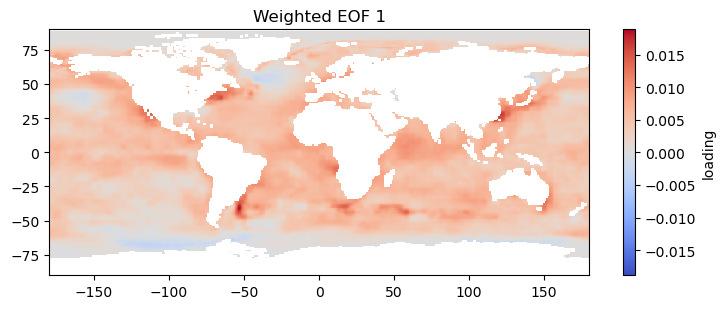

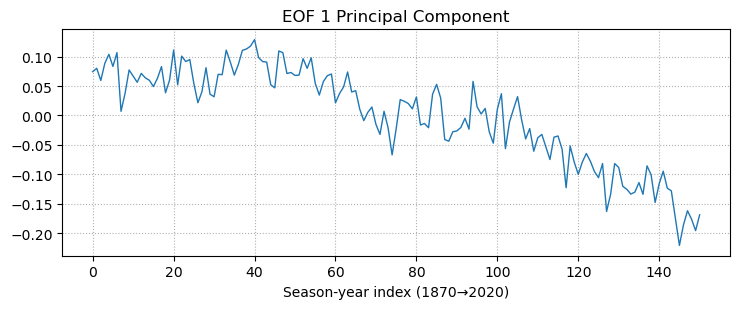

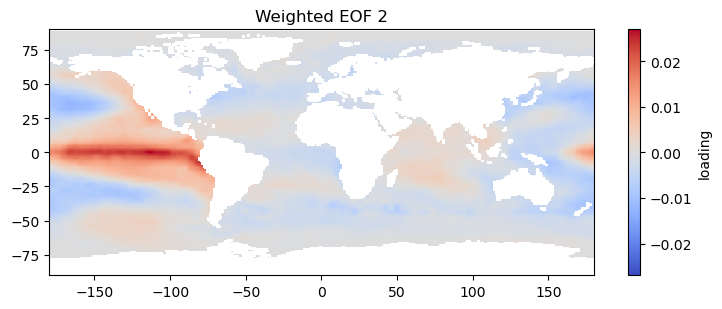

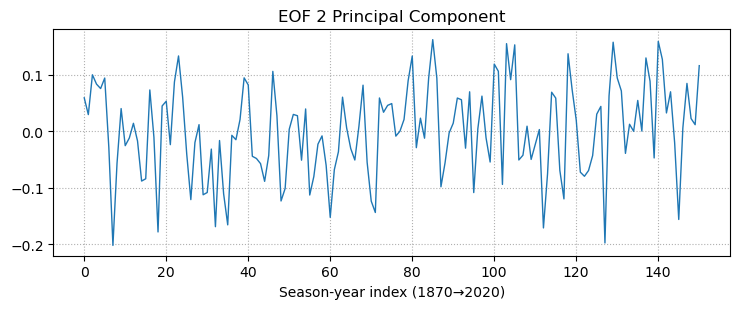

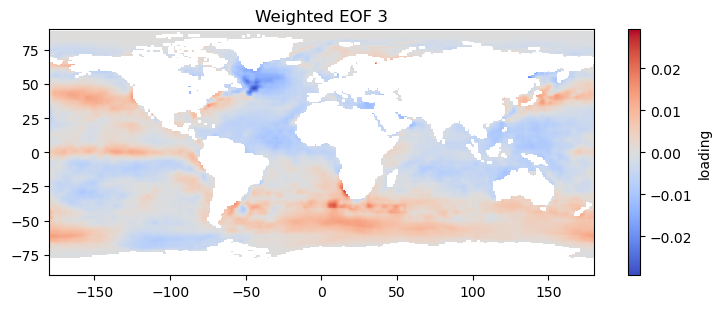

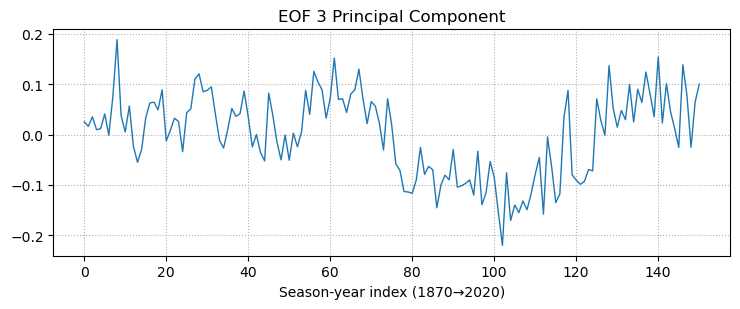

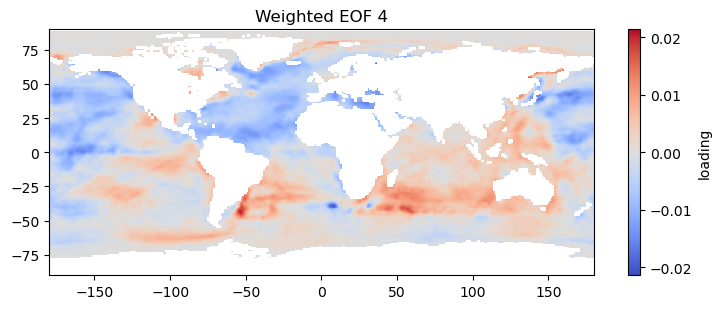

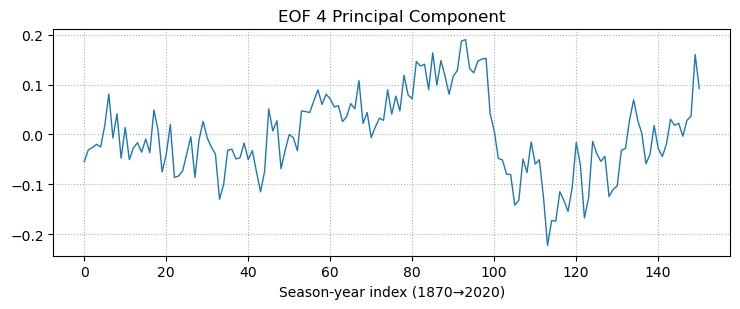

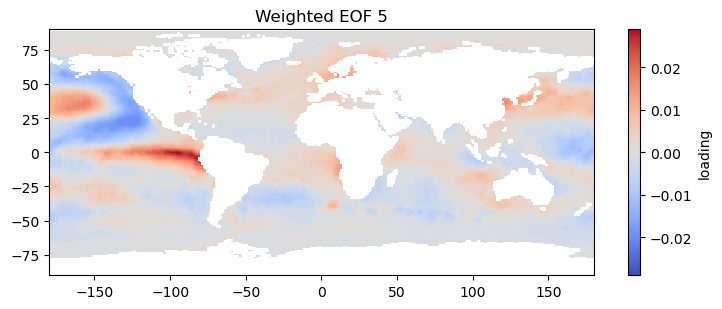

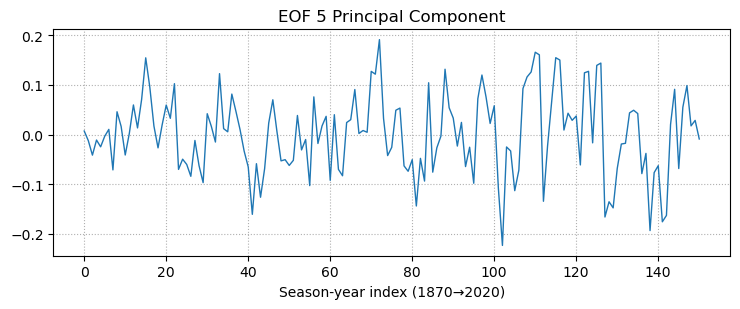

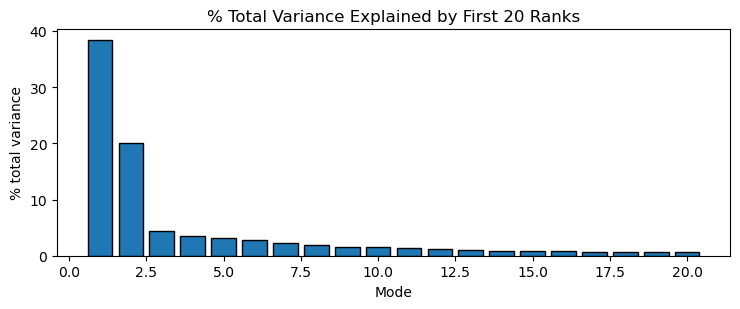


=== df_LIG (cores metadata with rounded coords) ===
                  ID  origin_lon  origin_lat  round_lon  round_lat
0      M23323-1_UK37        5.92       67.77        5.5       67.5
1             V28-14      -29.57       64.78      -29.5       64.5
2        EW9302-JPC8      -25.00       61.42      -24.5       61.5
3            ODP 980      -14.70       55.48      -14.5       55.5
4             V27-20      -46.20       54.00      -46.5       54.5
5           M23414-9      -20.29       53.53      -20.5       53.5
6            NEAP18k      -30.35       52.76      -30.5       52.5
7             V23-82      -21.93       52.58      -21.5       52.5
8             K708-1      -23.74       50.00      -23.5       50.5
9          MD04-2845       -5.22       45.35       -5.5       45.5
10           V29-179      -23.51       44.00      -23.5       44.5
11           SU92-03      -10.11       43.20      -10.5       43.5
12             D-117      -52.75       42.10      -52.5       42.5
13       

In [ ]:
# =====================================================================
# Containers for outputs
# =====================================================================
# Spatial/temporal patterns for first 5 modes → plotted below
# Variance explained bar → plotted below
# Full df_LIG printout → printed below
# First 5 time-steps of y′_{t,c} → collected
# Final reconstructions at key ages
T_key_phys = {}         # map age → (N_full,) with NaNs on land
T_all_phys = []         # optional: collect all time slices if desired

# =====================================================================
# STEP 16–24 : Build operators, errors; RSOI; T_t; de-weight; map
# =====================================================================

# Build the fixed H (n_cores × N), then slice to valid rows per t
H_bool = np.zeros((n_cores, N), dtype=bool)
for i, idx in row_lookup.items():
    H_bool[i, idx] = True
H = H_bool.astype(float)

# Variance explained (%)
var_pct = (s**2 / np.sum(s**2)) * 100.0

# === Plots required #1: spatial + temporal patterns for first 5 modes ===
for m in range(5):
    # Fill to full grid for plotting
    spatial_flat = np.full(N_full, np.nan)
    spatial_flat[valid_indices] = E[:, m]          # weighted EOF spatial pattern
    plot_mode_fields(spatial_flat, V[:, m], nlat, nlon, lats, lons, m)

# === Plots required #2: variance explained for first 20 modes ===
fig, ax = plt.subplots(figsize=(7.5, 3.2))
ax.bar(np.arange(1, 21), var_pct[:20], edgecolor="k")
ax.set_title("% Total Variance Explained by First 20 Ranks")
ax.set_xlabel("Mode"); ax.set_ylabel("% total variance")
plt.tight_layout(); plt.show()

# Cumulative percentage of total variance explained by the first 3 and 20 ranks
first_3_var = np.sum(var_pct[:3])
print(f"The first 3 terms explain {first_3_var} % of total variance. \n ")

first_20_var = np.sum(var_pct[:20])
print(f"The first 20 terms explain {first_20_var} % of total variance. \n ")

# === Print required #3: df_LIG (with rounded coords) ===
pd.set_option("display.max_rows", None)
print("\n=== df_LIG (cores metadata with rounded coords) ===")
print(df_LIG[["ID", "origin_lon", "origin_lat", "round_lon", "round_lat"]])

R_t_list = []    # store R_t for each time step
p_t_list = []    # store p_t (RSOI amplitudes) for each time step

# Loop over time slices (as stored: 115 → 130 ascending)
for t in range(151):
    age = ages_asc[t]

    # STEP 16: Selection at time t
    valid_core = (~np.isnan(Y[:, t])) & core_has_row
    if not np.any(valid_core):
        # Collect a placeholder for first y's if within first five times
        if t < 1:
            yprime_c_first.append(pd.DataFrame({"core_idx": [], "ID": [], "age_ka": age, "yprime_c": []}))
        T_all_phys.append(np.full(N_full, np.nan))
        continue

    H_t = H[valid_core, :]                           # (n_t × N)
    core_rows_t = np.where(valid_core)[0]
    grid_rows   = [row_lookup[i] for i in core_rows_t]  # grid row indices in ocean-only array

    # STEP 13: Weighted observations y′ (only the present rows)
    y_t_phys = Y[valid_core, t]                       # (n_t,)
    sqrtw_sel = sqrtw[grid_rows]                      # (n_t,)
    y_prime = sqrtw_sel * y_t_phys                    # (n_t,)

    # STEP 14: Summer correction in weighted space
    summer_sel = summer_mask[valid_core]              # (n_t,)
    if np.any(summer_sel):
        y_prime[summer_sel] = y_prime[summer_sel] - x_Aug_prime[grid_rows][summer_sel]

    # STEP 15: Centralize with weighted mean x′
    y_prime_c = y_prime - x_prime[grid_rows]          # (n_t,)

    # Save first time-steps of y′_{t,c} for print
    if t < 1:
        df_first = pd.DataFrame({
            "core_idx": core_rows_t,
            "ID": df_LIG.ID.values[core_rows_t],
            "age_ka": age,
            "yprime_c": y_prime_c
        })
        yprime_c_first.append(df_first)

    # STEP 16: 𝓗_t = H_t E (n_t × r)
    Hcal = H_t[:, grid_rows] * 0.0   # placeholder not used; we build directly below
    Hcal = np.stack([E[grid_rows, k] for k in range(r)], axis=1)   # (n_t, r)

    # STEP 17–18: Residual-mode covariance and Obs error (weighted)
    # Residual variance diagonal at the observed rows:
    if E_tilde.shape[1] > 0:
        E_tilde_slice = E_tilde[grid_rows, :]                         # (n_t, T-r)
        red_diag = (E_tilde_slice**2) @ lam_tilde_vec                 # (n_t,)
    else:
        red_diag = np.zeros_like(y_prime_c)

    # Observational variance at time t (physical σ), then weight by w_i:
    sigma_t = Sigma[valid_core, t]                                    # (n_t,)
    obs_diag = (sqrtw_sel**2) * (sigma_t**2)                          # = w_i σ_i^2

    # STEP 19: Total error R_t (n_t × n_t) – diagonal in this construction
    R_t = np.diag(red_diag + obs_diag)

    # STEP 20: RSOI (first form) p_t = Λ 𝓗_tᵀ (𝓗_t Λ 𝓗_tᵀ + R_t)^{-1} y′_{t,c}
    # Build M = 𝓗_t Λ 𝓗_tᵀ + R_t
    M = Hcal @ Λ @ Hcal.T + R_t  # (n_t, n_t)

    try:
        # Solve M x = y′ for x, then p_t = Λ 𝓗_tᵀ x
        x_sol = np.linalg.solve(M, y_prime_c)               # (n_t,)
        p_t = Λ @ (Hcal.T @ x_sol)                          # (r,)
    except np.linalg.LinAlgError:
        # If ill-conditioned or singular, we flag by printing and skip this frame
        print(f"[FLAG] (𝓗Λ𝓗ᵀ + R)_t is singular/ill-cond at age={age:.1f} ka; skipping reconstruction.")
        T_all_phys.append(np.full(N_full, np.nan))
        continue

    # STEP 21: Weighted full-field anomaly T_t = E p_t  (N,)
    T_t = E @ p_t
    
    # STEP 21.5: Store full matrix and amplitude as lists for later debugging
    R_t_list.append(R_t.copy())     # store full matrix (diagonal)
    p_t_list.append(p_t.copy())     # store amplitude vector

    # STEP 22: Physical anomalies (de-weight once)
    T_phys = np.zeros(N)
    nonzero = sqrtw > 0
    T_phys[nonzero] = T_t[nonzero] / sqrtw[nonzero]
    T_phys[~nonzero] = np.nan

    # STEP 23: Remap to 180×360 with land as NaN
    field_full = np.full(N_full, np.nan)
    field_full[valid_indices] = T_phys

    # Keep full field
    T_all_phys.append(field_full)

    # STEP 24: Store requested slices (130, 127, 125, 120, 115 ka)
    # ages_asc is ascending; we’ll map exact columns elsewhere for plotting,
    # but here we just collect per-step, so handle after the loop.


=== First time-step of y_t (centralized, weighted) ===
    core_idx                ID  age_ka  yprime_c
0          0     M23323-1_UK37   115.0 -0.009020
1          1            V28-14   115.0 -0.005486
2          2       EW9302-JPC8   115.0 -0.006272
3          3           ODP 980   115.0 -0.006081
4          4            V27-20   115.0  0.005315
5          5          M23414-9   115.0 -0.008956
6          6           NEAP18k   115.0 -0.016246
7          7            V23-82   115.0 -0.007611
8          8            K708-1   115.0 -0.003329
9          9         MD04-2845   115.0 -0.005165
10        10           V29-179   115.0 -0.003148
11        11           SU92-03   115.0 -0.011793
12        12             D-117   115.0  0.001649
13        13          CH69-K09   115.0 -0.013398
14        14            V30-97   115.0 -0.009300
15        15    MD95-2040_UK37   115.0  0.001420
16        16           SU90-03   115.0 -0.009103
17        17    MD01-2444_UK37   115.0  0.005648
18        18 

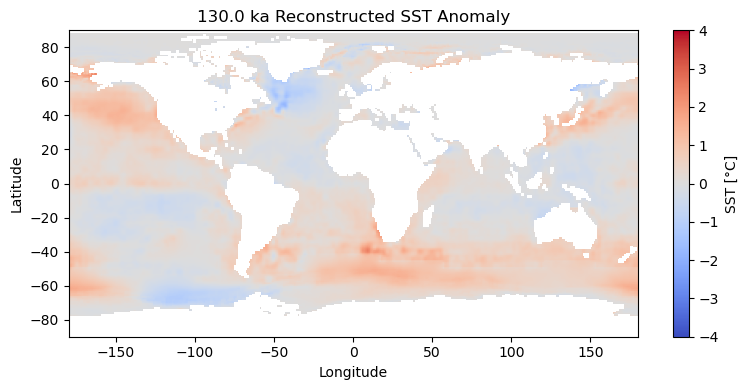

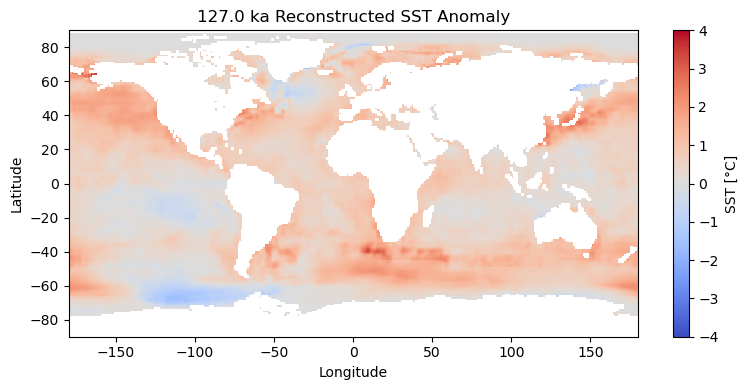

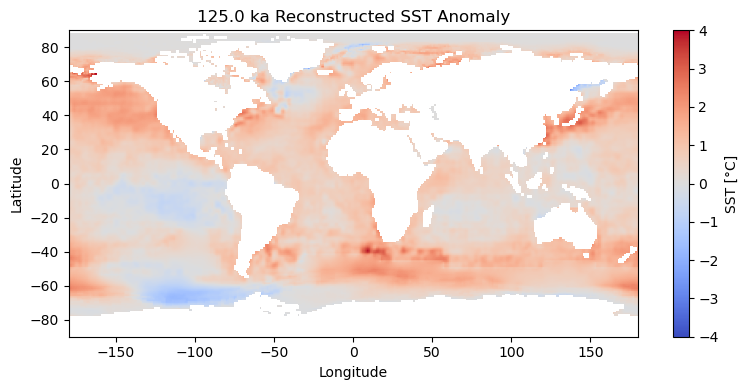

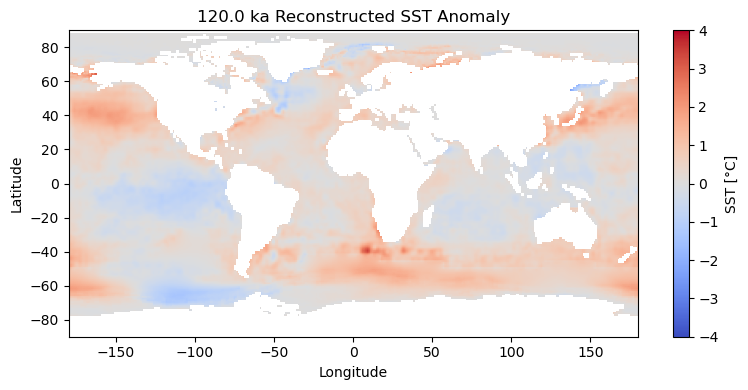

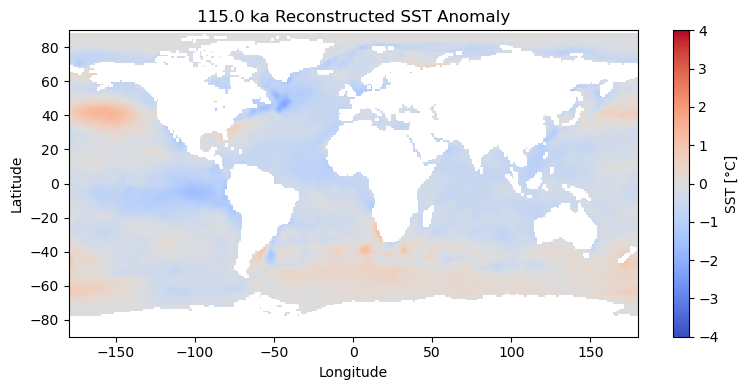

In [5]:
# =====================================================================
# Key timeslices prints/plots
# =====================================================================

# Print required #4: first time-step of centralized, weighted y_t
print("\n=== First time-step of y_t (centralized, weighted) ===")
if len(yprime_c_first) > 0:
    yprime_c_first_df = pd.concat(yprime_c_first, ignore_index=True)
    print(yprime_c_first_df)
else:
    print("(no valid observations found in first five steps)")

# Plot required #5: Final reconstructions at ages 130, 127, 125, 120, 115 Kya
lats_flat = np.repeat(lats[:, None], nlon, axis=1)
lons_flat = np.repeat(lons[None, :], nlat, axis=0)
for age in key_ages:
    # Map age → column index in ascending ages
    idx = nearest_index_age(ages_asc, age)
    if idx < len(T_all_phys):
        field_full = T_all_phys[idx].reshape(nlat, nlon)
        vmax = 4.0
        plt.figure(figsize=(8, 4))
        plt.imshow(field_full, origin='lower', extent=[-180, 180, -90, 90],
                   cmap='coolwarm', vmin=-vmax, vmax=vmax, aspect='auto')
        plt.title(f"{age:.1f} ka Reconstructed SST Anomaly")
        plt.colorbar(label="SST [°C]")
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        plt.tight_layout()
        plt.show()
    else:
        print(f"[FLAG] Missing reconstruction for age {age:.1f} ka")

SST-anomaly animation saved → 1204_LIG_SST_RSOI.gif


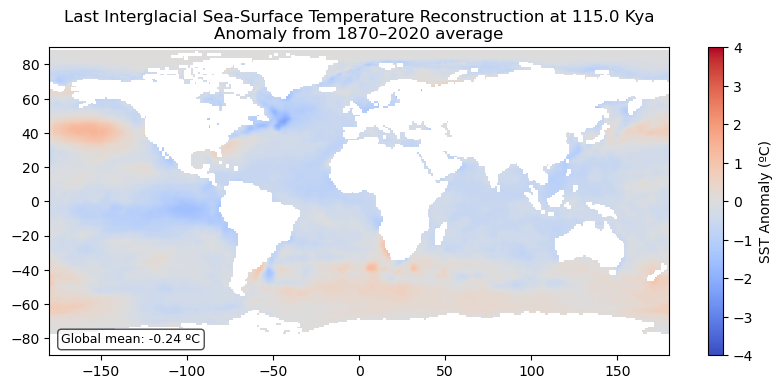

In [6]:
# ─────────────────────────────────────────────────────────────
# Build per-frame rasters from T_all_phys (phys anomalies)
# ─────────────────────────────────────────────────────────────
# Assumes the following already exist from your reconstruction:
#   - T_all_phys : list of length 151; each item is (N_full,) with NaNs on land
#   - nlat, nlon : grid shape
#   - ages_asc   : np.linspace(115.0, 130.0, 151)  (ascending ages)

N_full = nlat * nlon
anomaly_maps = []
mins, maxs = [], []

for t in range(151):
    if t < len(T_all_phys) and T_all_phys[t] is not None:
        flat = T_all_phys[t]
    else:
        flat = np.full(N_full, np.nan)

    field = flat.reshape(nlat, nlon)
    anomaly_maps.append(field)
    if np.isfinite(field).any():
        mins.append(np.nanmin(field))
        maxs.append(np.nanmax(field))

vmin, vmax = -4.0, 4.0

# ─────────────────────────────────────────────────────────────
# Animation 130.0 → 115.0 kya (descending age)
# ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
initial_idx = 150  # 130.0 kya (since ages_asc is 115→130 ascending)
im = ax.imshow(
    anomaly_maps[initial_idx],
    origin="lower", extent=[-180, 180, -90, 90],
    cmap="coolwarm", vmin=vmin, vmax=vmax, aspect="auto"
)
cbar = fig.colorbar(im, ax=ax, label="SST Anomaly (ºC)")

title = ax.set_title(
    f"Last Interglacial Sea-Surface Temperature Reconstruction at {115.0 + 0.1*initial_idx:.1f} Kya\n"
    "Anomaly from 1870–2020 average"
)
gm_text = ax.text(
    0.02, 0.04, "", transform=ax.transAxes,
    fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

def update(frame):
    # Play backward in age: 130.0 → 115.0 kya
    idx = 150 - frame
    age = 115.0 + 0.1 * idx

    im.set_array(anomaly_maps[idx])
    title.set_text(
        f"Last Interglacial Sea-Surface Temperature Reconstruction at {age:.1f} Kya\n"
        "Anomaly from 1870–2020 average"
    )
    gm = np.nanmean(anomaly_maps[idx])
    gm_text.set_text(f"Global mean: {gm:+.2f} ºC")

    return im, title, gm_text

anim = animation.FuncAnimation(fig, update, frames=151, blit=True)

# Save (choose one or both)
gif_path = "1204_LIG_SST_RSOI.gif"
anim.save(gif_path, writer=animation.PillowWriter(fps=30))
print(f"SST-anomaly animation saved → {gif_path}")

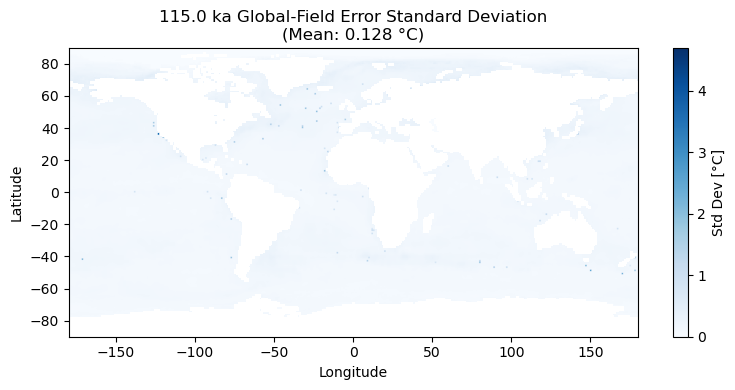

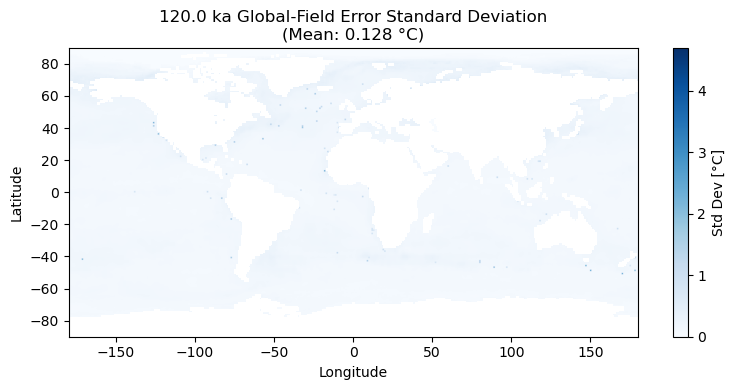

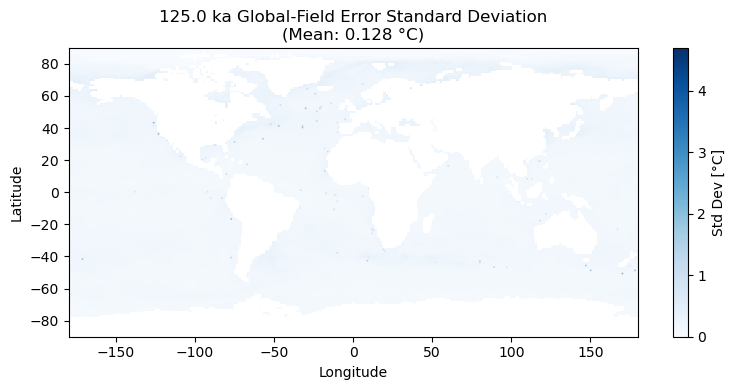

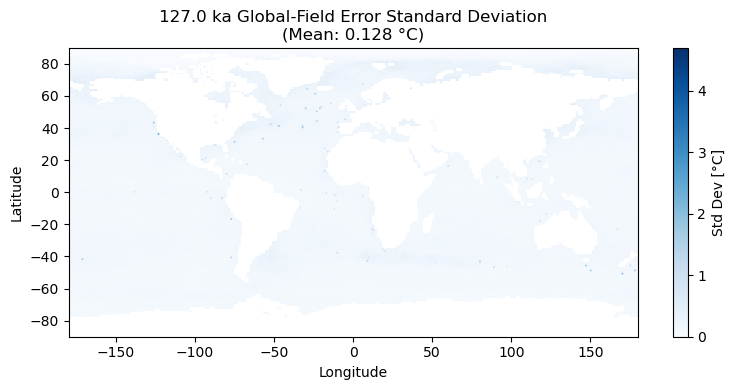

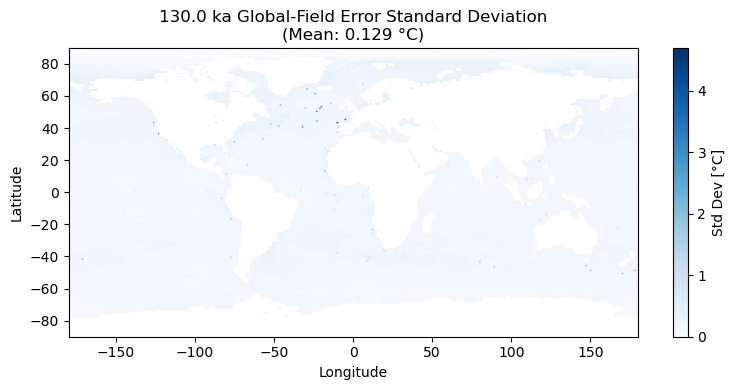

In [8]:
# ────────────────────────────────────────────────────────────────
# Global-field R_t error standard deviation mapping
# ────────────────────────────────────────────────────────────────
# Compute std(R_t) at ALL ocean grid points for each time step,
# then visualize as global imshow maps (not scatter/bubble maps).

def rt_std_phys_global_field(t, E_tilde, lam_tilde_vec, Y, Sigma, sqrtw, row_lookup):
    """
    Compute physical std dev sqrt(R_t_ii) at ALL ocean grid points at time t.
    This differs from rt_std_phys_for_time() which only computes at observed sites.
    
    Returns:
        std_phys_field : (N,) array with std in physical space (°C) at all ocean points
    """
    n_sites = Y.shape[0]
    
    # Identify which sites contribute at this time
    valid_site = ~np.isnan(Y[:, t])
    site_idx   = np.where(valid_site)[0]
    grid_rows_obs = np.array([row_lookup[i] for i in site_idx], dtype=int)
    
    # Initialize output: std at all ocean grid points
    std_phys_all = np.zeros(N)
    
    # For OBSERVED sites only, compute their R_t contributions
    if np.any(valid_site):
        # rank-reduction variance at observed rows (weighted space)
        if E_tilde.shape[1] > 0:
            Et_slice = E_tilde[grid_rows_obs, :]         # (n_t × (T-r))
            red_var  = (Et_slice**2) @ lam_tilde_vec     # (n_t,)
        else:
            red_var  = np.zeros(np.sum(valid_site), dtype=float)
        
        # observational variance at time t, in weighted space: w_i * sigma_i^2
        sigma_t = Sigma[site_idx, t]                     # (n_t,) in °C
        obs_var = (sqrtw[grid_rows_obs]**2) * (sigma_t**2)
        
        # total variance in weighted obs-space at observed rows
        Rt_diag_obs = red_var + obs_var
        
        # convert to physical std (°C) for observed rows
        std_phys_obs = np.where(
            sqrtw[grid_rows_obs] > 0,
            np.sqrt(Rt_diag_obs) / sqrtw[grid_rows_obs],
            np.nan
        )
        
        # place observational errors at their grid points
        std_phys_all[grid_rows_obs] = std_phys_obs
    
    # For UNOBSERVED grid points, compute only rank-reduction variance
    # (no observational error since there are no data)
    unobserved_mask = np.ones(N, dtype=bool)
    unobserved_mask[grid_rows_obs] = False
    unobserved_rows = np.where(unobserved_mask)[0]
    
    if len(unobserved_rows) > 0 and E_tilde.shape[1] > 0:
        Et_unobs = E_tilde[unobserved_rows, :]           # (n_unobs × (T-r))
        red_var_unobs = (Et_unobs**2) @ lam_tilde_vec    # (n_unobs,)
        
        # convert to physical std (°C) for unobserved rows
        std_phys_unobs = np.where(
            sqrtw[unobserved_rows] > 0,
            np.sqrt(red_var_unobs) / sqrtw[unobserved_rows],
            np.nan
        )
        std_phys_all[unobserved_rows] = std_phys_unobs
    
    return std_phys_all


# Compute R_t std at all ocean points for all times
rt_std_global_all = []
for t in range(151):
    std_field = rt_std_phys_global_field(t, E_tilde, lam_tilde_vec, Y, Sigma, sqrtw, row_lookup)
    rt_std_global_all.append(std_field)

# Find global max std across all times for consistent colorbar scaling
global_std_max = np.nanmax([np.nanmax(s) for s in rt_std_global_all if np.isfinite(s).any()])

# Plot static uncertainty maps at selected ages
ages_to_plot = [115.0, 120.0, 125.0, 127.0, 130.0]

for age in ages_to_plot:
    idx = nearest_index_age(ages_asc, age)
    
    # Get global-field std (N,) and reshape to (nlat, nlon)
    std_ocean = rt_std_global_all[idx]
    
    # Remap to full grid with NaN on land
    std_full = np.full(N_full, np.nan)
    std_full[valid_indices] = std_ocean
    std_field = std_full.reshape(nlat, nlon)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(
        std_field,
        origin='lower',
        extent=[-180, 180, -90, 90],
        cmap='Blues',
        vmin=0,
        vmax=global_std_max,
        aspect='auto'
    )
    cbar = fig.colorbar(im, ax=ax, label='Std Dev [°C]')
    
    # Compute and display mean std dev
    mean_std = np.nanmean(std_ocean)
    ax.set_title(f'{age:.1f} ka Global-Field Error Standard Deviation\n(Mean: {mean_std:.3f} °C)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    
    plt.tight_layout()
    plt.show()


Saved → 1208_LIG_R_t_global.gif


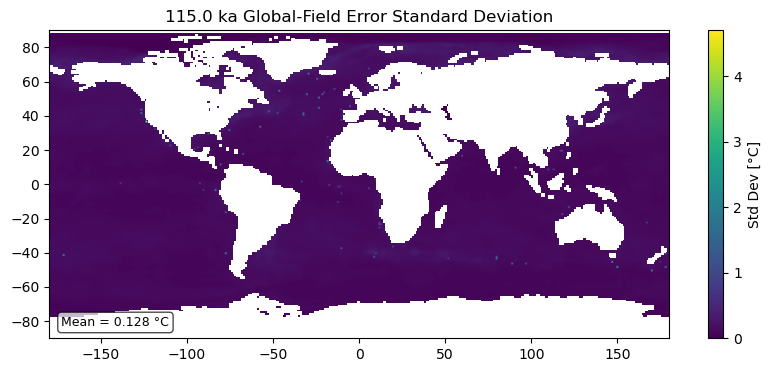

In [10]:
# Output animation for global-field R_t error standard deviation
# Build full-grid rasters from `rt_std_global_all` and animate 130.0 → 115.0 ka

# Remap list of ocean-only std fields -> full-grid (nlat × nlon) arrays
global_std_maps = []
for t in range(151):
    std_ocean = rt_std_global_all[t]
    std_full = np.full(N_full, np.nan)
    std_full[valid_indices] = std_ocean
    global_std_maps.append(std_full.reshape(nlat, nlon))

# Animation (130.0 → 115.0 ka; ages_asc is ascending 115→130)
fig, ax = plt.subplots(figsize=(10, 4))
initial_idx = 150  # corresponds to 130.0 ka
im = ax.imshow(
    global_std_maps[initial_idx],
    origin='lower', extent=[-180, 180, -90, 90],
    cmap='viridis', vmin=0, vmax=global_std_max, aspect='auto'
)
cbar = fig.colorbar(im, ax=ax, label='Std Dev [°C]')

title = ax.set_title(f"{115.0 + 0.1*initial_idx:.1f} ka Global-Field Error Standard Deviation")
mean_text = ax.text(
    0.02, 0.04, "", transform=ax.transAxes,
    fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

def update(frame):
    # play 130.0 → 115.0 kya
    idx = 150 - frame
    age = 115.0 + 0.1 * idx

    im.set_array(global_std_maps[idx])
    mean_std = np.nanmean(rt_std_global_all[idx])
    # Update title + small mean label
    title.set_text(
        f"{age:.1f} ka Global-Field Error Standard Deviation"
    )
    mean_text.set_text(f"Mean = {mean_std:.3f} °C")

    return im, title, mean_text

anim_global = animation.FuncAnimation(fig, update, frames=151, blit=True)

# Save GIF
gif_path = "1208_LIG_R_t_global.gif"
anim_global.save(gif_path, writer=animation.PillowWriter(fps=30))
print(f"Saved → {gif_path}")


Saved → 1204_LIG_R_t_bubbles.gif


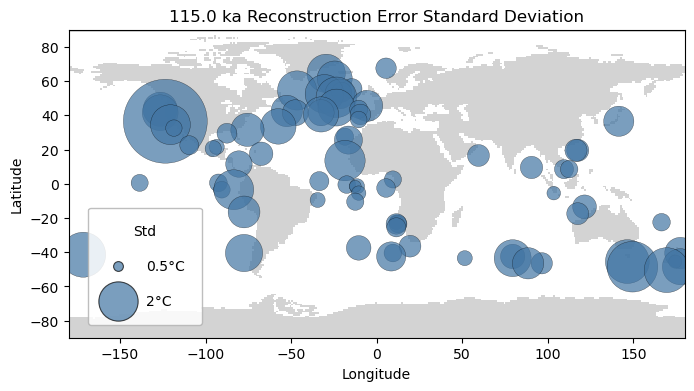

In [ ]:
from matplotlib.colors import ListedColormap

# ---------- helpers to compute per-time site uncertainty and colors ----------

def rt_std_phys_for_time(t, E_tilde, lam_tilde_vec, row_lookup, Y, Sigma, sqrtw):
    """
    Compute site-wise physical std dev sqrt(diag(R_t))/sqrt(w_i) at time t.
    Returns (site_idx, std_phys, grid_rows) where std_phys is in °C.
    """
    n_sites = Y.shape[0]
    valid_site = ~np.isnan(Y[:, t])  # sites that contribute at this time
    if not np.any(valid_site):
        return np.array([], dtype=int), np.array([]), np.array([], dtype=int)

    site_idx  = np.where(valid_site)[0]
    grid_rows = np.array([row_lookup[i] for i in site_idx], dtype=int)

    # rank-reduction variance at observed rows (weighted space)
    if E_tilde.shape[1] > 0:
        Et_slice = E_tilde[grid_rows, :]               # (n_t × (T-r))
        red_var  = (Et_slice**2) @ lam_tilde_vec       # (n_t,)
    else:
        red_var  = np.zeros_like(grid_rows, dtype=float)

    # observational variance at time t, in weighted space: w_i * sigma_i^2
    sigma_t = Sigma[site_idx, t]                       # (n_t,) in °C
    obs_var = (sqrtw[grid_rows]**2) * (sigma_t**2)

    # total variance in weighted obs-space, convert to physical std (°C)
    Rt_diag     = red_var + obs_var
    std_phys    = np.where(sqrtw[grid_rows] > 0, np.sqrt(Rt_diag) / sqrtw[grid_rows], np.nan)

    return site_idx, std_phys, grid_rows

# def site_colors_from_field(idx, T_all_phys, valid_indices, grid_rows):
#    """
#    Get reconstructed physical anomaly at each site's grid cell for frame idx.
#    Returns (values_in_°C).
#    """
#    field_flat = T_all_phys[idx]  # (N_full,)
#    # map ocean-only row -> full-grid flat index
#    full_flat_rows = valid_indices[grid_rows]
#    return field_flat[full_flat_rows]  # (n_t,)

# ---------- build static site lon/lat arrays ----------
core_lons = df_LIG.round_lon.values
core_lats = df_LIG.round_lat.values

# ---------- set up the animation ----------
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(-180, 180); ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

# ---- static background: continents (land=light grey, ocean=white) ----
ocean_mask_full = np.full((nlat, nlon), False)
ocean_mask_full.flat[valid_indices] = True        # True on ocean cells
land_bg = (~ocean_mask_full).astype(float)        # 1 = land, 0 = ocean

cmap_bg = ListedColormap(['white', 'lightgrey'])
im_bg = ax.imshow(
    land_bg,
    origin='lower',
    extent=[-180, 180, -90, 90],
    cmap=cmap_bg,
    vmin=0, vmax=1,
    interpolation='nearest',
    zorder=0
)

# keep bubbles on top of the background
ax.set_facecolor('white')

initial_idx = 150  # 130.0 kya (since ages_asc is 115→130 ascending)
# initial valid sites, sizes, colors
site_idx0, std_phys0, grid_rows0 = rt_std_phys_for_time(
    initial_idx, E_tilde, lam_tilde_vec, row_lookup, Y, Sigma, sqrtw
)
xs0 = core_lons[site_idx0]; ys0 = core_lats[site_idx0]
# cols0 = site_colors_from_field(initial_idx, T_all_phys, valid_indices, grid_rows0)

# marker sizes: area ~ (std_phys)^2 for perceptual proportionality (1°C → ~200 pts²)
# tweak the scale (size_scale) to taste
size_scale = 200.0
s0 = size_scale * (np.clip(std_phys0, 0, None) ** 2)

scat = ax.scatter(
    xs0, ys0, s=s0, c='#4275A3', alpha=0.7,
    edgecolors="k", linewidths=0.25
)
# cbar = fig.colorbar(scat, ax=ax, label="Reconstructed anomaly (°C)")

title = ax.set_title(
    f"{115.0 + 0.1*initial_idx:.1f} ka Reconstruction Error Standard Deviation"
)

# --- bubble-size legend (bottom-left) ---
# choose a few reference σ values in °C (tweak as you like)
sigma_levels = [0.5, 2.0]   # °C

# convert to marker areas using the same size law as the plot
legend_sizes = [size_scale * (s**2) for s in sigma_levels]

ax = plt.gca()  # current axes (works whether you used plt.subplots or pyplot)

# make hollow circle handles so colorbar meaning stays clear
handles = [
    plt.scatter([], [], s=sz,c= '#4275A3',facecolors='white', alpha=0.7, edgecolors='k', linewidths=0.8)
    for sz in legend_sizes
]
labels = [f"{s:g}°C" for s in sigma_levels]

legend = ax.legend(
    handles, labels,
    title="Std",
    loc="lower left", bbox_to_anchor=(0.02, 0.02),
    frameon=True, framealpha=0.85, facecolor='white', edgecolor='0.7', 
    labelspacing=1.5, borderpad=1.2, handletextpad=1.0
    )
legend.set_zorder(3)  # keep above background

def update(frame):
    # play 130.0 → 115.0 kya
    idx = 150 - frame
    age = 115.0 + 0.1 * idx

    site_idx, std_phys, grid_rows = rt_std_phys_for_time(
        idx, E_tilde, lam_tilde_vec, row_lookup, Y, Sigma, sqrtw
    )
    xs = core_lons[site_idx]; ys = core_lats[site_idx]
    # cols = site_colors_from_field(idx, T_all_phys, valid_indices, grid_rows)

    # update scatter: offsets, sizes, colors
    if xs.size:
        offsets = np.column_stack((xs, ys))
    else:
        offsets = np.empty((0, 2))
    scat.set_offsets(offsets)
    # size ∝ (std_phys)^2; guard against negatives/NaNs
    sizes = size_scale * (np.clip(std_phys, 0, None) ** 2)
    scat.set_sizes(sizes)
    # scat.set_array(cols)

    title.set_text(
        f"{age:.1f} ka Reconstruction Error Standard Deviation"
    )
    return scat, title

anim = animation.FuncAnimation(fig, update, frames=151, blit=True)

# Save at 30 fps
gif_path = "1204_LIG_R_t_bubbles.gif"
anim.save(gif_path, writer=animation.PillowWriter(fps=30))
print(f"Saved → {gif_path}")


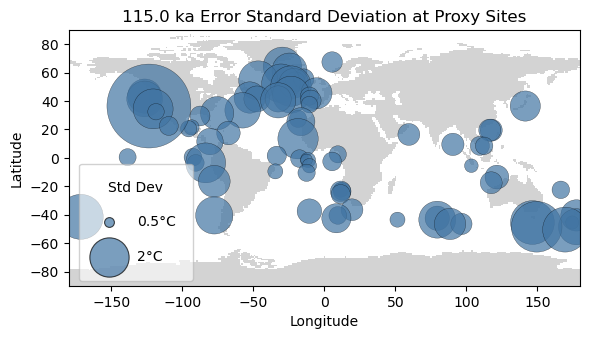

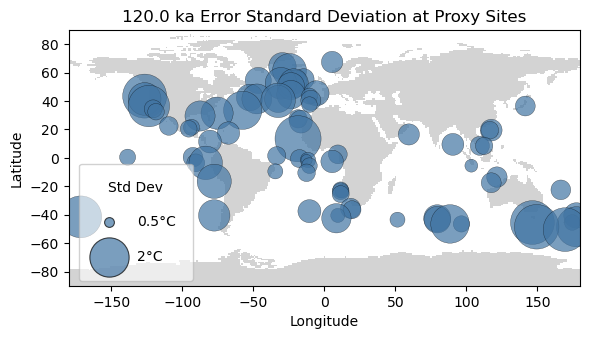

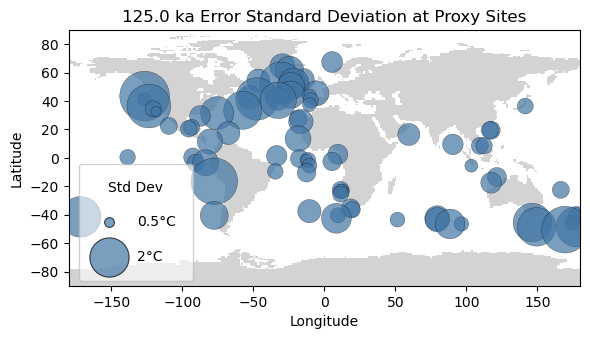

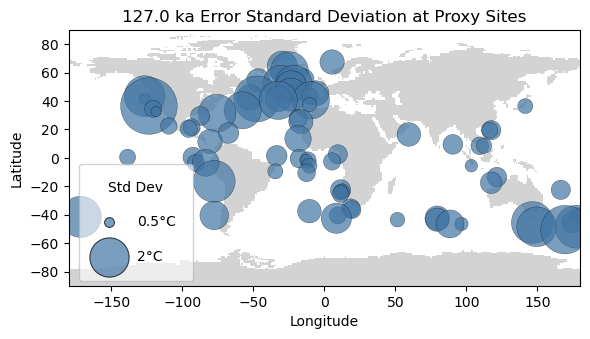

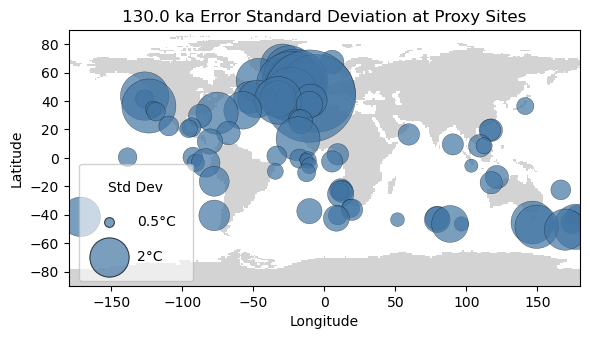

In [ ]:
# Plot static uncertainty-bubble maps at selected ages
ages_to_plot = [115.0, 120.0, 125.0, 127.0, 130.0]
for age in ages_to_plot:
    idx = nearest_index_age(ages_asc, age)
    site_idx, std_phys, grid_rows = rt_std_phys_for_time(idx, E_tilde, lam_tilde_vec, row_lookup, Y, Sigma, sqrtw)
    # cols = site_colors_from_field(idx, T_all_phys, valid_indices, grid_rows)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.imshow(land_bg, origin='lower', extent=[-180,180,-90,90], cmap=cmap_bg, vmin=0, vmax=1, interpolation='nearest', zorder=0)
    sc = ax.scatter(core_lons[site_idx], core_lats[site_idx], s=size_scale*(np.clip(std_phys,0, None)**2), c='#4275A3', alpha=0.7, edgecolors='k', linewidths=0.25)
    # fig.colorbar(sc, ax=ax, label='SST [°C]')

    # bubble-size legend (small local defs so cell is self-contained)
    sigma_levels_local = [0.5, 2.0]
    legend_sizes_local = [size_scale * (s**2) for s in sigma_levels_local]
    handles_local = [ax.scatter([], [], s=sz, c='#4275A3', alpha=0.7, facecolors='none', edgecolors='k', linewidths=0.8) for sz in legend_sizes_local]
    labels_local = [f"{s:g}°C" for s in sigma_levels_local]
    legend = ax.legend(handles_local, labels_local, title="Std Dev", loc=(0.02, 0.02), frameon=True, framealpha=0.6, facecolor='white', edgecolor='0.7', labelspacing=1.5, borderpad=1.2, handletextpad=1.0)
    legend.set_zorder(3)

    ax.set_title(f'{age:.1f} ka Error Standard Deviation at Proxy Sites')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180,180)
    ax.set_ylim(-90,90)
    plt.tight_layout()
    plt.show()

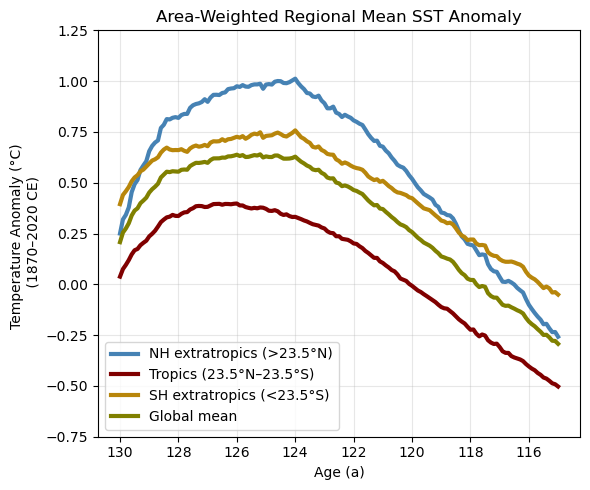

In [ ]:
# ------------------------------------------------------------
# Regional Mean by Latitude Band using area-weighted T_t
# ------------------------------------------------------------

# Time axis (ascending 115 → 130)
years = ages_asc.copy()

# Latitude grids & masks (full grid)
lat_vals   = lats                      # shape (nlat,)
lat_grid   = np.repeat(lat_vals[:, None], nlon, axis=1)   # 180×360

nh_mask_full   =  lat_grid >  23.5
trop_mask_full = (lat_grid >= -23.5) & (lat_grid <= 23.5)
sh_mask_full   =  lat_grid < -23.5
all_ocean_full = np.full((nlat, nlon), False)
all_ocean_full.flat[valid_indices] = True               # True on ocean cells

# Convert full-grid masks → ocean-only index positions (0..N-1)
nh_pos   = np.where(nh_mask_full.reshape(-1)[valid_indices])[0]
trop_pos = np.where(trop_mask_full.reshape(-1)[valid_indices])[0]
sh_pos   = np.where(sh_mask_full.reshape(-1)[valid_indices])[0]
all_pos  = np.arange(len(valid_indices))

# Precompute denominators (sum w over band) once
nh_denom   = np.nansum(w[nh_pos])
trop_denom = np.nansum(w[trop_pos])
sh_denom   = np.nansum(w[sh_pos])
all_denom  = np.nansum(w[all_pos])

nh_series, trop_series, sh_series, global_series = [], [], [], []

for t in range(151):
    # ocean-only physical anomalies for this time (length N)
    ocean_phys = T_all_phys[t][valid_indices]  # (N,)
    # weighted-space vector T_t = sqrtw * T_phys
    T_t_ocean = sqrtw * ocean_phys

    # numerators: sum( sqrtw * T_t ) over band == sum( w * T_phys ) over band
    nh_num   = np.nansum( np.sqrt(w[nh_pos])   * T_t_ocean[nh_pos] )
    trop_num = np.nansum( np.sqrt(w[trop_pos]) * T_t_ocean[trop_pos] )
    sh_num   = np.nansum( np.sqrt(w[sh_pos])   * T_t_ocean[sh_pos] )
    all_num  = np.nansum( np.sqrt(w[all_pos])  * T_t_ocean[all_pos] )

    # band means in °C (physical)
    nh_series.  append(nh_num   / nh_denom if nh_denom   > 0 else np.nan)
    trop_series.append(trop_num / trop_denom if trop_denom > 0 else np.nan)
    sh_series.  append(sh_num   / sh_denom if sh_denom   > 0 else np.nan)
    global_series.append(all_num / all_denom if all_denom > 0 else np.nan)

nh_series   = np.array(nh_series)
trop_series = np.array(trop_series)
sh_series   = np.array(sh_series)
global_series = np.array(global_series)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.plot(years, nh_series,     color='steelblue',      linewidth=3, label='NH extratropics (>23.5°N)')
plt.plot(years, trop_series,   color='maroon',         linewidth=3, label='Tropics (23.5°N–23.5°S)')
plt.plot(years, sh_series,     color='darkgoldenrod',  linewidth=3, label='SH extratropics (<23.5°S)')
plt.plot(years, global_series, color='olive',          linewidth=3, label='Global mean')

plt.gca().invert_xaxis()  # show 130 → 115 left to right
plt.title('Area-Weighted Regional Mean SST Anomaly')
plt.xlabel('Age (a)');  plt.ylabel('Temperature Anomaly (°C) \n (1870–2020 CE)')
plt.grid(alpha=0.3)
plt.legend(loc='lower left')
plt.ylim(-0.75, 1.25)
plt.tight_layout()
plt.show()